## OBJECTIVE : To group countries into different categories and identify if they need finanacial assistance

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_colwidth',None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
desc = pd.read_csv('data-dictionary.csv')

In [3]:
desc

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 1000 live births
2,exports,Exports of goods and services per capita. Given as %age of the GDP per capita
3,health,Total health spending per capita. Given as %age of GDP per capita
4,imports,Imports of goods and services per capita. Given as %age of the GDP per capita
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of the Total GDP
7,life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
8,total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
9,gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.


In [4]:
country_df = pd.read_csv('Country-data.csv')
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
# exports,health,imports are given in percentage of GDP

#converting to its actual value

country_df[['exports', 'health', 'imports']] = (country_df[['exports', 'health', 'imports']]).multiply(country_df["gdpp"]/100, axis="index")

In [6]:
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [7]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


### we don't have any null value in our dataset

<Axes: >

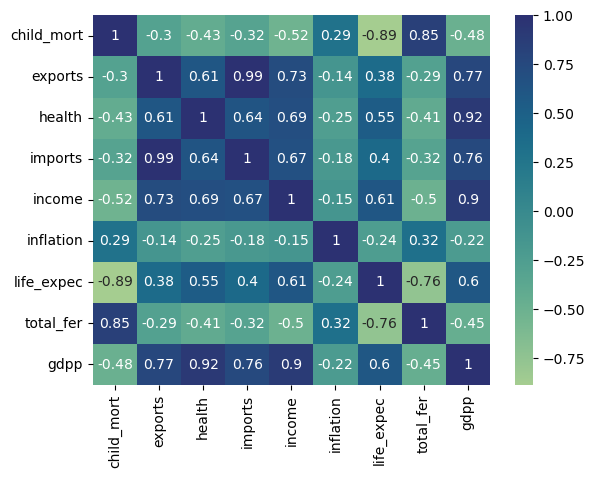

In [8]:
# Find correlation among the columns

sns.heatmap(country_df.corr(numeric_only=True),annot=True,cmap='crest')

Following feature pairs are highly corelated (Positively or negatively)

-imports and exports (correlation factor = 0.99)

-health and gdpp (correlation factor = 0.92)

-income and gdpp (correlation factor = 0.9)

-life_expce and child_mort (correlation factor = -0.89)

-total_fer and child_mort (correlation factor = 0.85)

In [9]:
# describing the data

country_df.describe(percentiles=[.25,.50,.75,.90,.95])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,17760.600000,3825.416000,15034.280000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


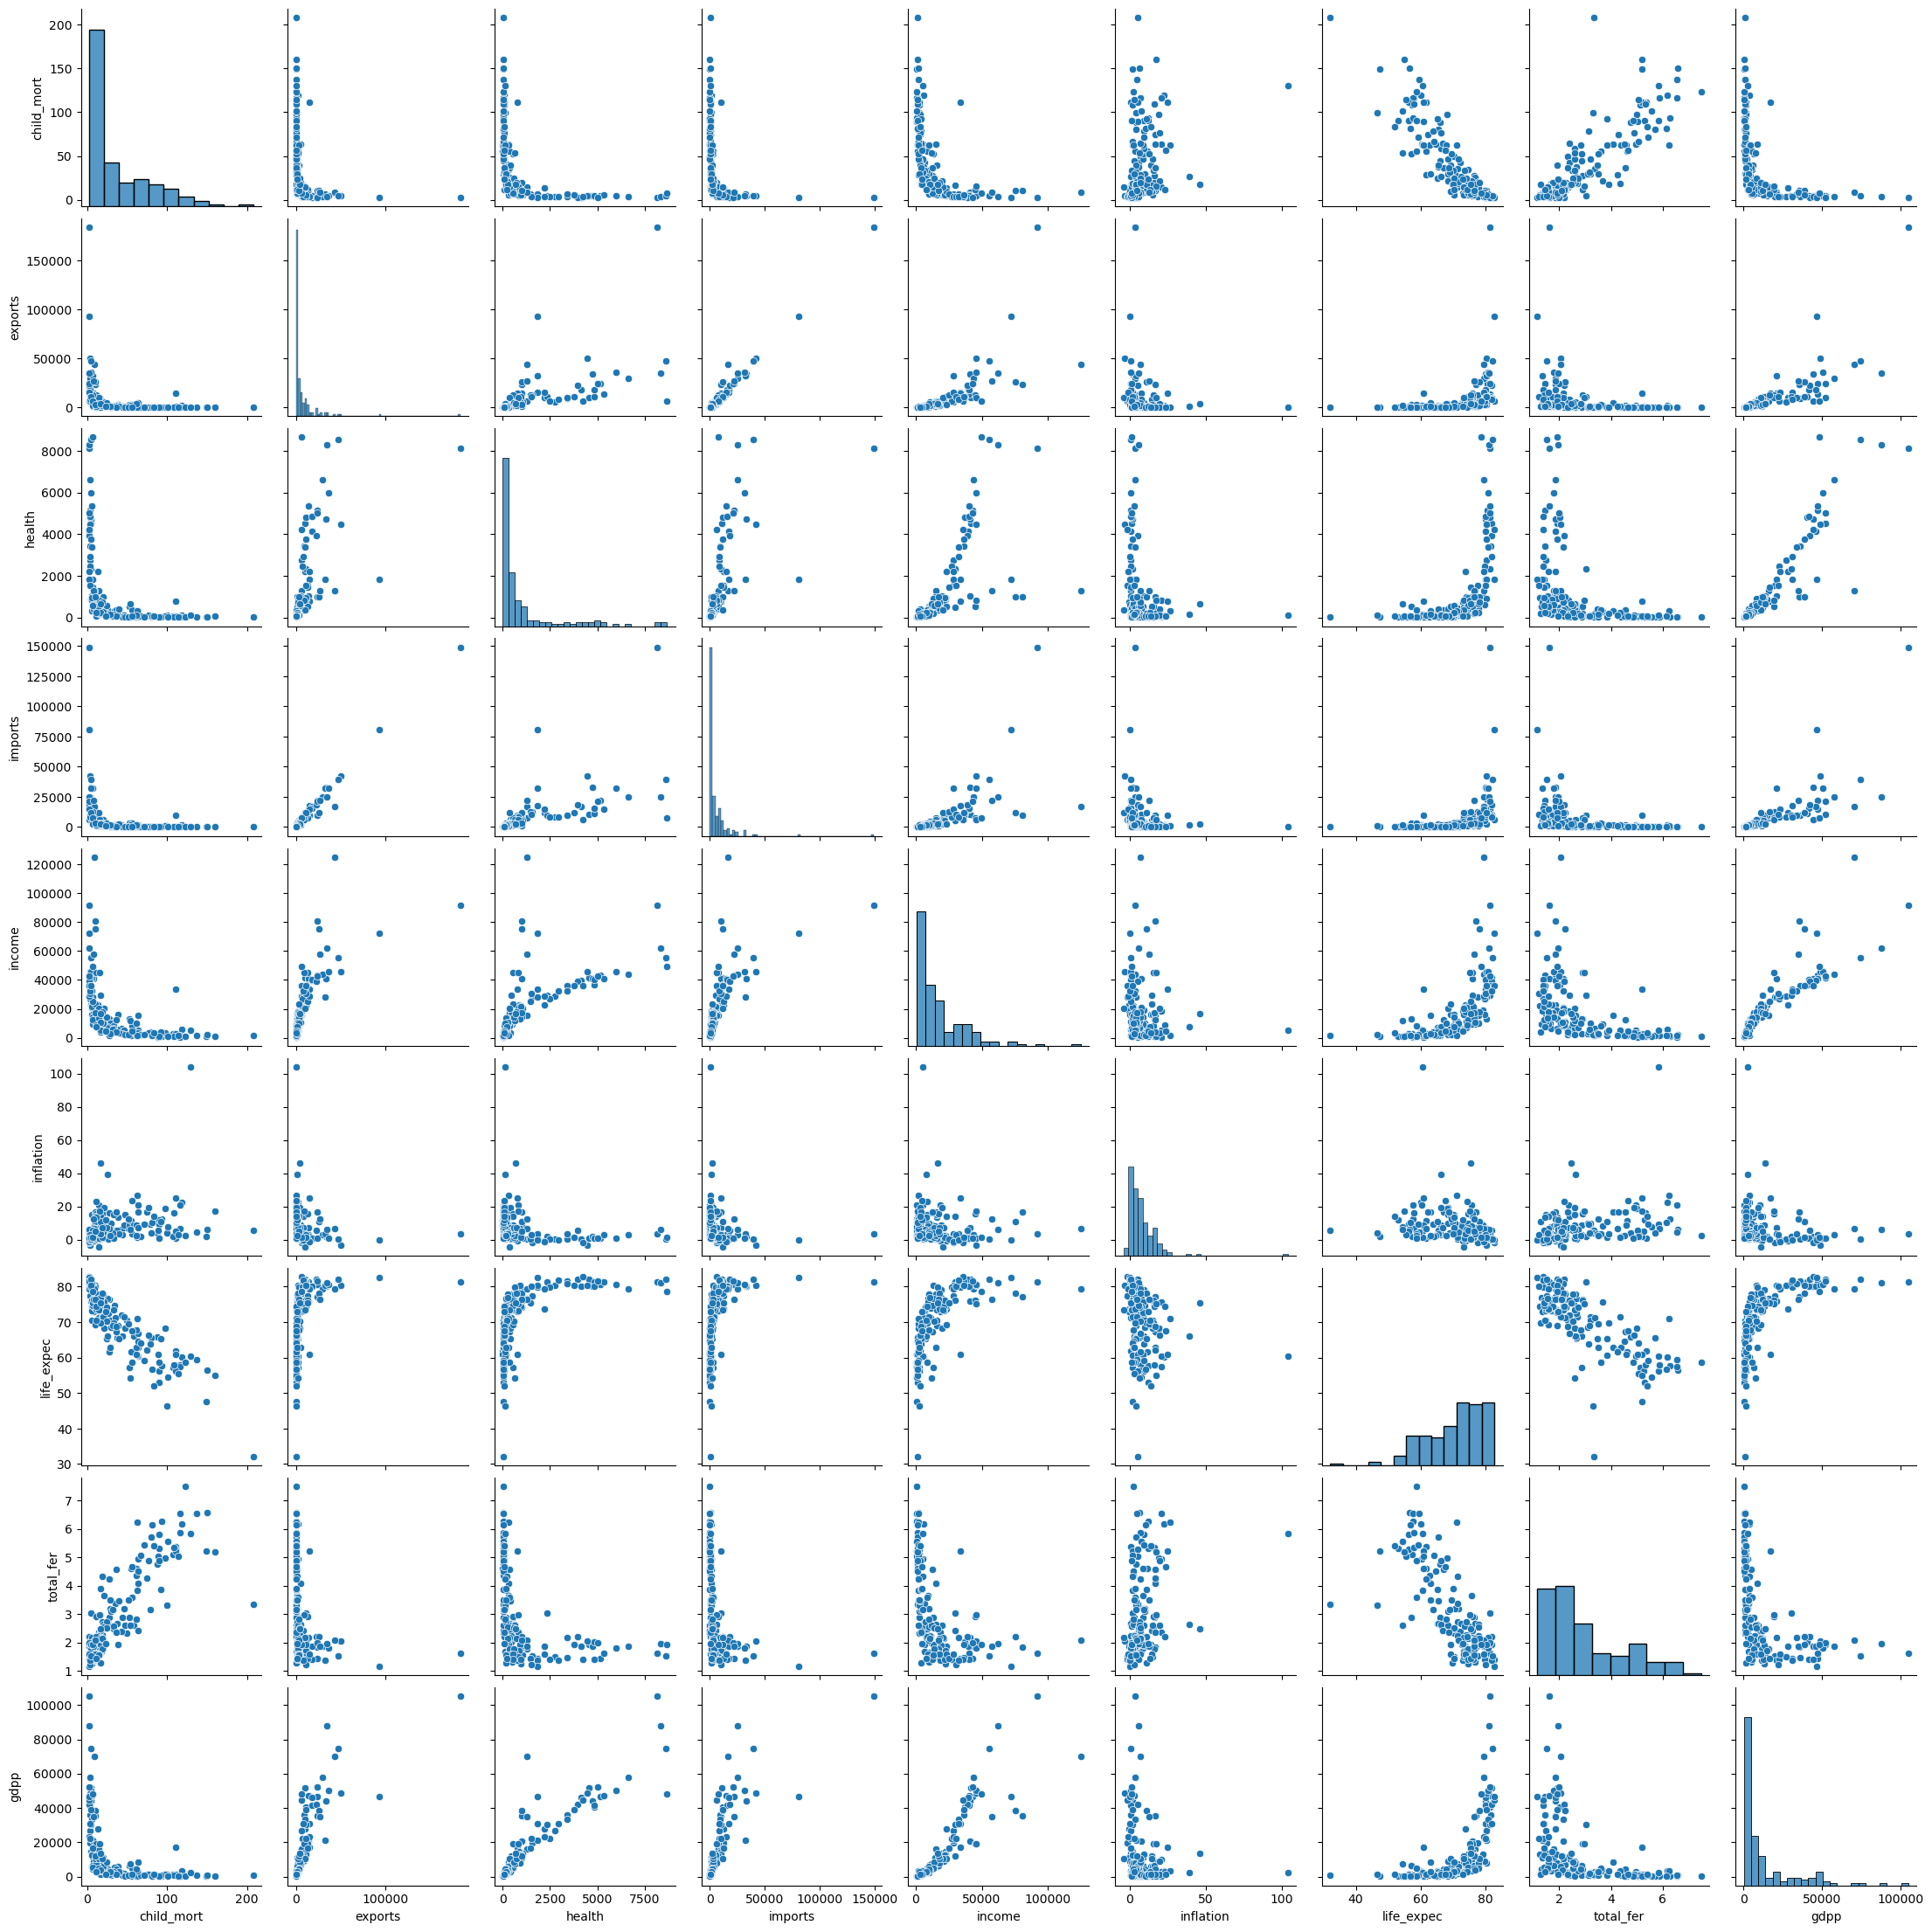

In [10]:
# Bivariate Analysis


sns.pairplot(country_df)
plt.show()


## Observations

- gdpp is linearly related with exports, health, imports, income. (positively correlated)

- child_mort is negatively correlated with life_expec (greater the   child mortality, lesser the life expectancy)
  and positively correlated with total_fer

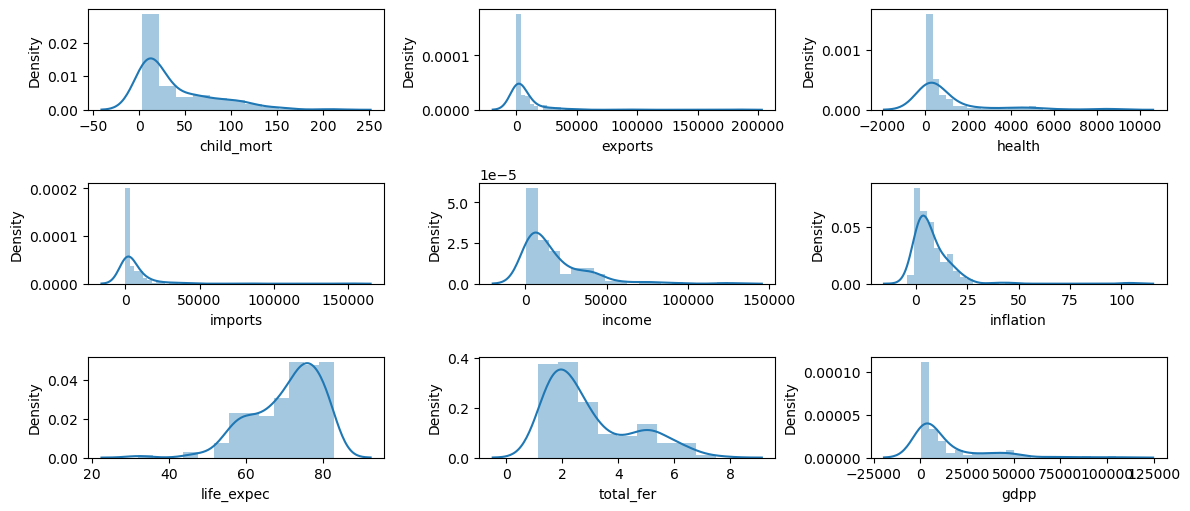

In [11]:
# Univariate analysis


fig=plt.subplots(figsize=(12, 10))

for i, feature in enumerate(country_df.drop('country', axis=1).columns):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace = 2.0)
    sns.distplot(country_df[feature])
    plt.tight_layout()

### Observation

-  Except Life expectancy (life_expec) all the features are right-    skewed.

## Handling Outliers

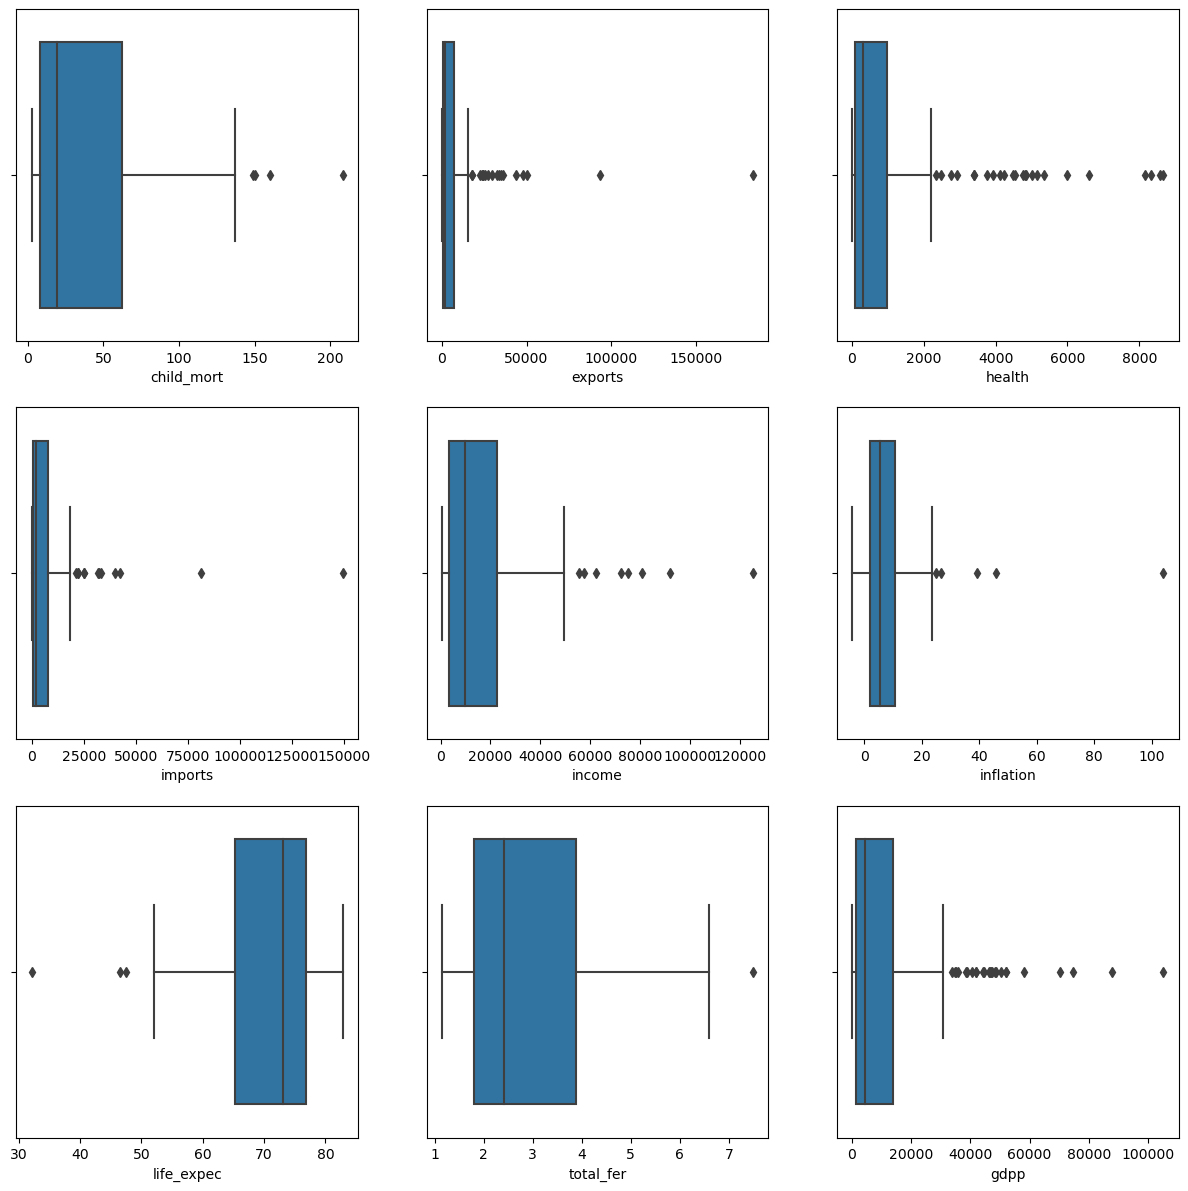

In [12]:
fig = plt.figure(figsize=(15,25))
for plot, feature in enumerate(country_df.columns[1:]):
    fig.add_subplot(5,3,plot+1)
    sns.boxplot(x=country_df[feature], data=country_df)

 From the above plots, we can conculde the following:

-  There are outliers in each features.
-  Most of the outliers are in health, exports and gdpp
-  There are only 167 rows(countries), so removing these outliers    will delete the crucial information from the datesets.
-  Specially the countries which have exceptionally high child        mortalities(outliers), will be missed, which actually need the    aid from the NGO. For example, in case of Child Mortality rate,    country with value 208 is an outlierm, however, the coutry        itself could in dire need of aid.
-  So I chose to treat the outliers only in the gdpp column. The      coutries with high gdpp would not require an aid. So I will        remove those from the dataset.

In [13]:
#Caluclating the quantile1 and quantile3 for gdpp and removing the upper outliers
Q1 = country_df.gdpp.quantile(0.05)
Q3 = country_df.gdpp.quantile(0.95)

country_df[(country_df.gdpp > Q3)]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
7,Australia,4.8,10276.2,4530.87,10847.1,41400,1.160,82.0,1.93,51900
44,Denmark,4.1,29290.0,6612.00,25288.0,44000,3.220,79.5,1.87,58000
73,Ireland,4.2,50161.0,4475.53,42125.5,45700,-3.220,80.4,2.05,48700
91,Luxembourg,2.8,183750.0,8158.50,149100.0,91700,3.620,81.3,1.63,105000
110,Netherlands,4.5,36216.0,5985.70,31990.8,45500,0.848,80.7,1.79,50300
114,Norway,3.2,34856.6,8323.44,25023.0,62300,5.950,81.0,1.95,87800
123,Qatar,9.0,43796.9,1272.43,16731.4,125000,6.980,79.5,2.07,70300
144,Sweden,3.0,24070.2,5017.23,21204.7,42900,0.991,81.5,1.98,52100
145,Switzerland,4.5,47744.0,8579.00,39761.8,55500,0.317,82.2,1.52,74600


### In the above table we can see, that Qatar is having a high child mortality rate of 9.0, but its other features like gdpp, total_fertility rate, income etc are in the higher range. So it would not be first in the list of needy countries.

After removing the outlier

In [14]:
countries = country_df[(country_df.gdpp <= Q3)]

In [15]:
countries.shape

(158, 10)

In [16]:
countries.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


<Figure size 2000x3500 with 0 Axes>

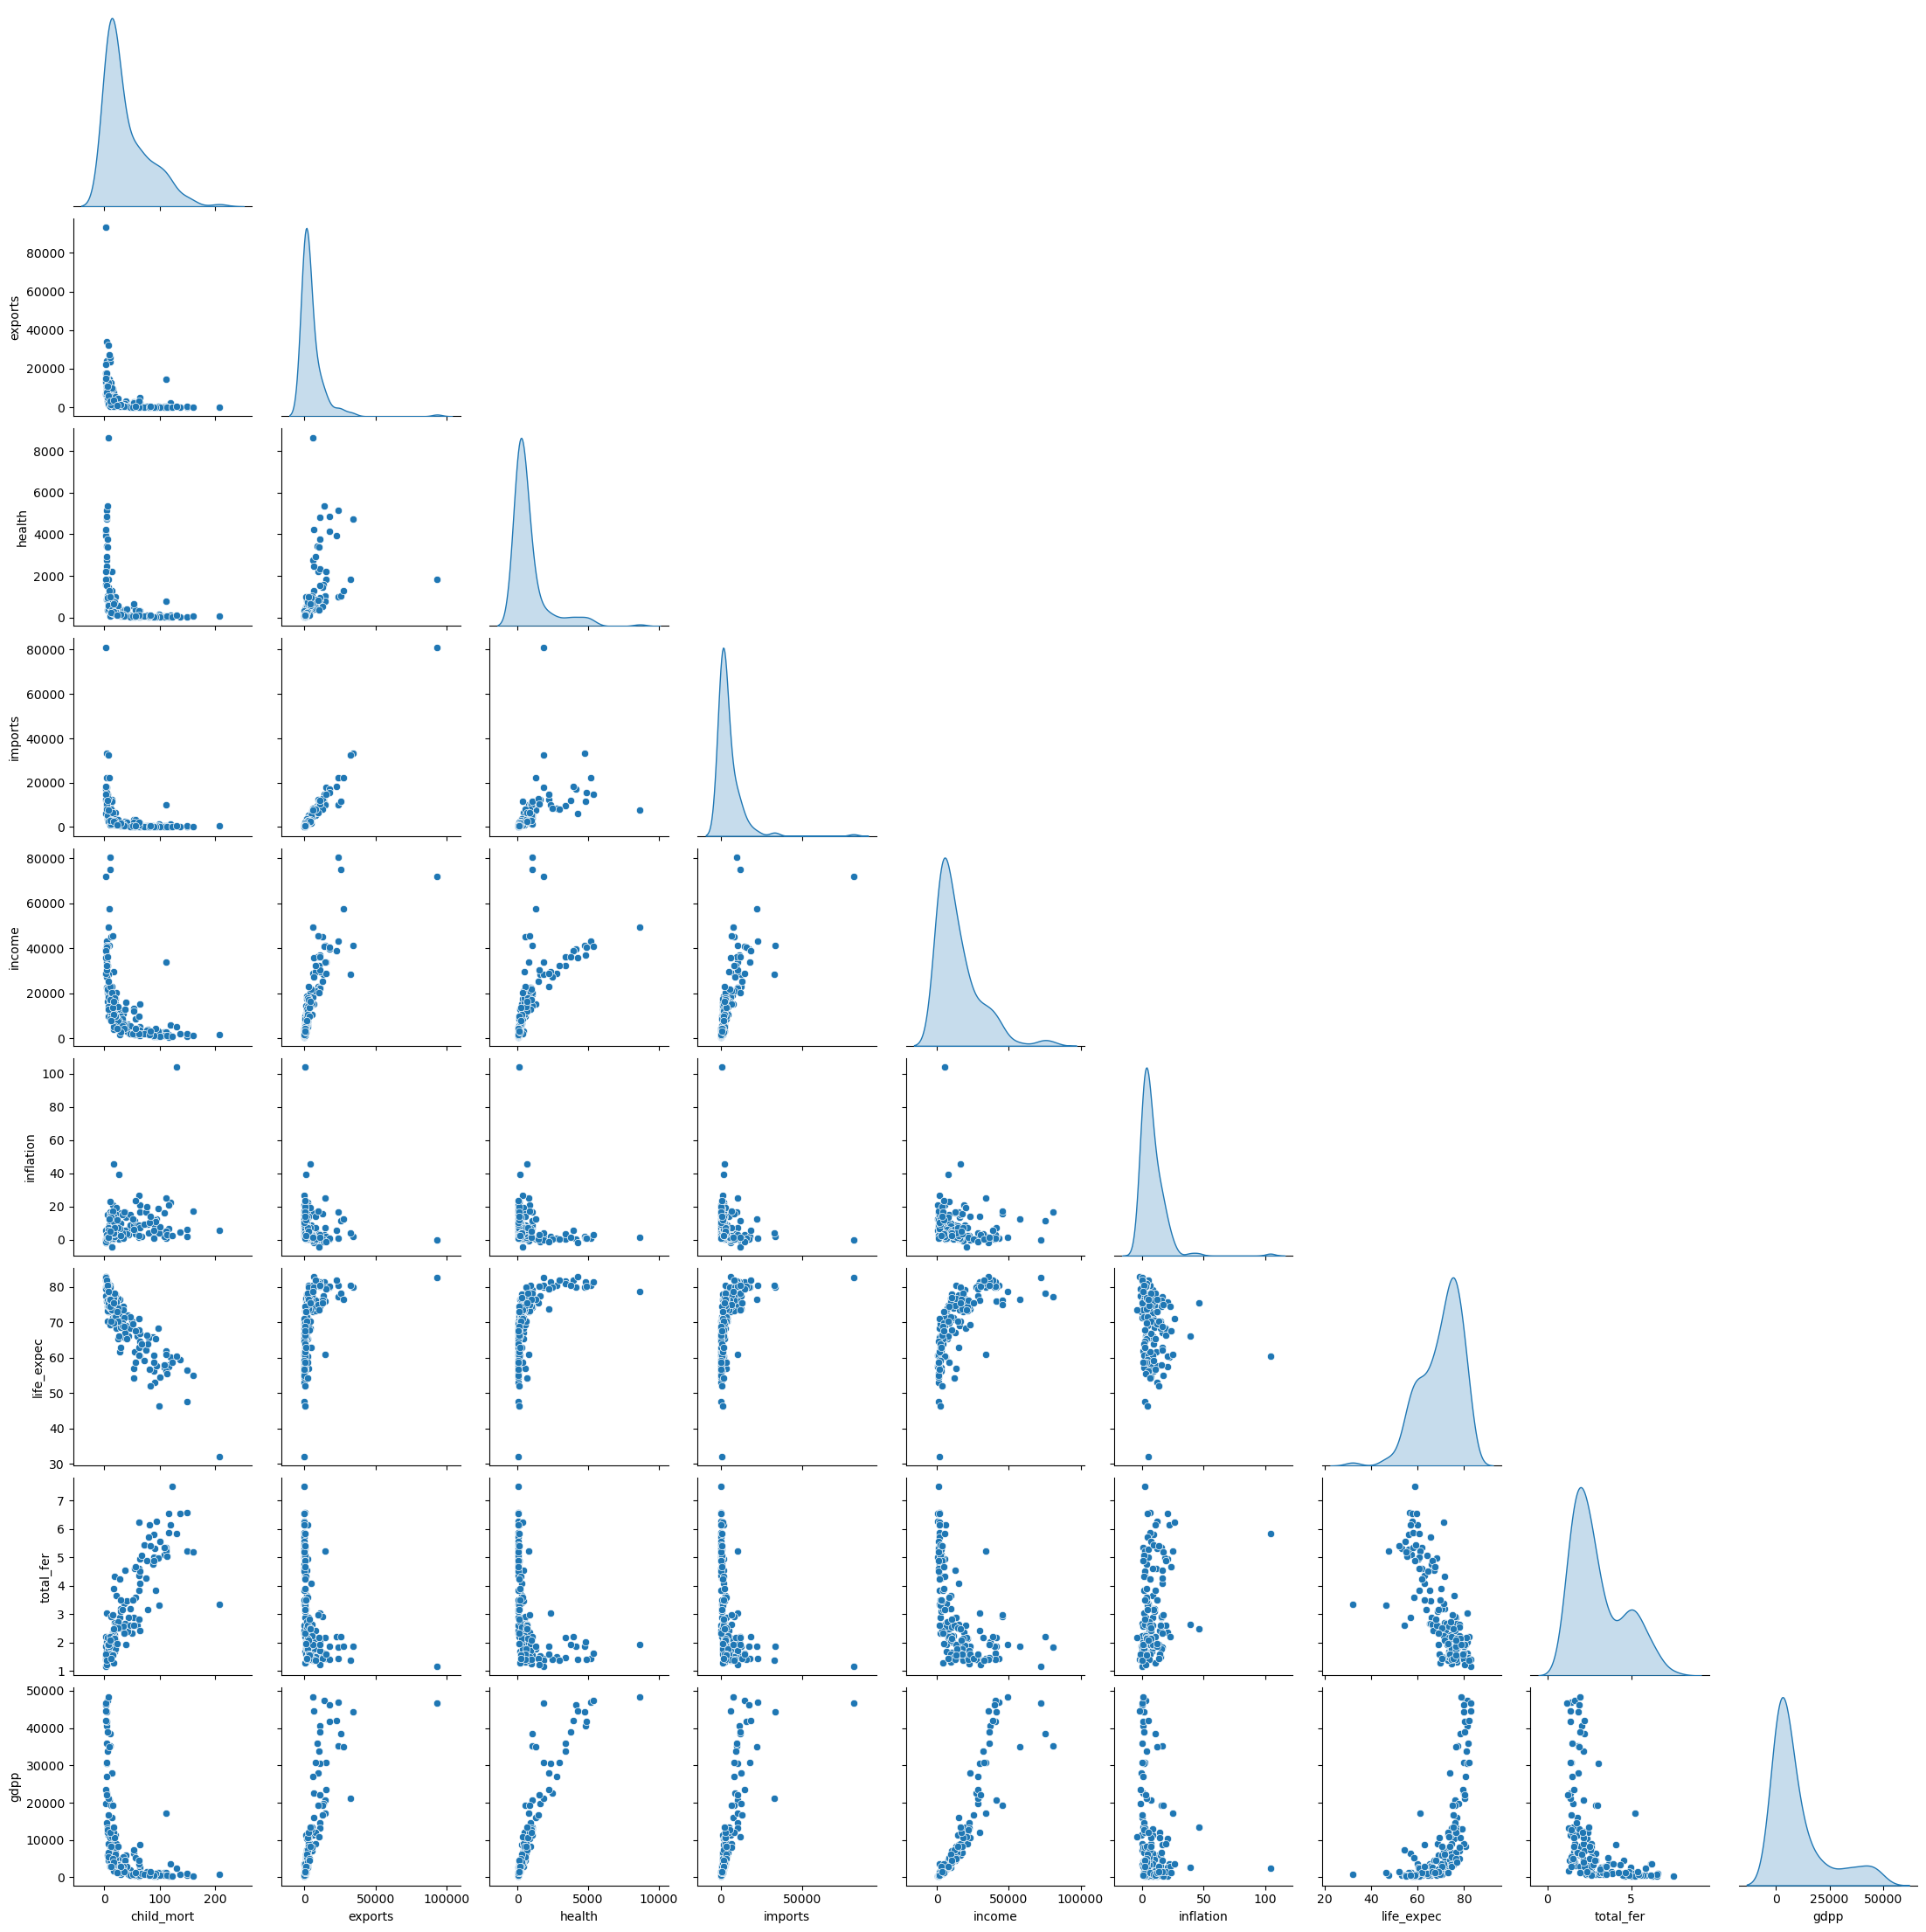

In [17]:
### Visulaizing the data using pair plot

fig = plt.figure(figsize=(20,35))
sns.pairplot(countries,diag_kind='kde',corner=True)

From the above plots we can conclude the following about gddp

-  It is highly and positively correlated with life expectancy and    income
-  It is inversely correlated with child_mortality, total            fertility and inflation
-  health, imports and exports are also positively correlated with    gddp
-  Also there is linear realtionship between gdpp vs                  income,imports vs exports, total_fer vs child_mort

### Top 10 under developed countries based on the data visulaization

#### Top 10 countries with highest mortality rate

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Haiti'),
  Text(1, 0, 'Sierra Leone'),
  Text(2, 0, 'Chad'),
  Text(3, 0, 'Central African Republic'),
  Text(4, 0, 'Mali'),
  Text(5, 0, 'Nigeria'),
  Text(6, 0, 'Niger'),
  Text(7, 0, 'Angola'),
  Text(8, 0, 'Congo, Dem. Rep.'),
  Text(9, 0, 'Burkina Faso')])

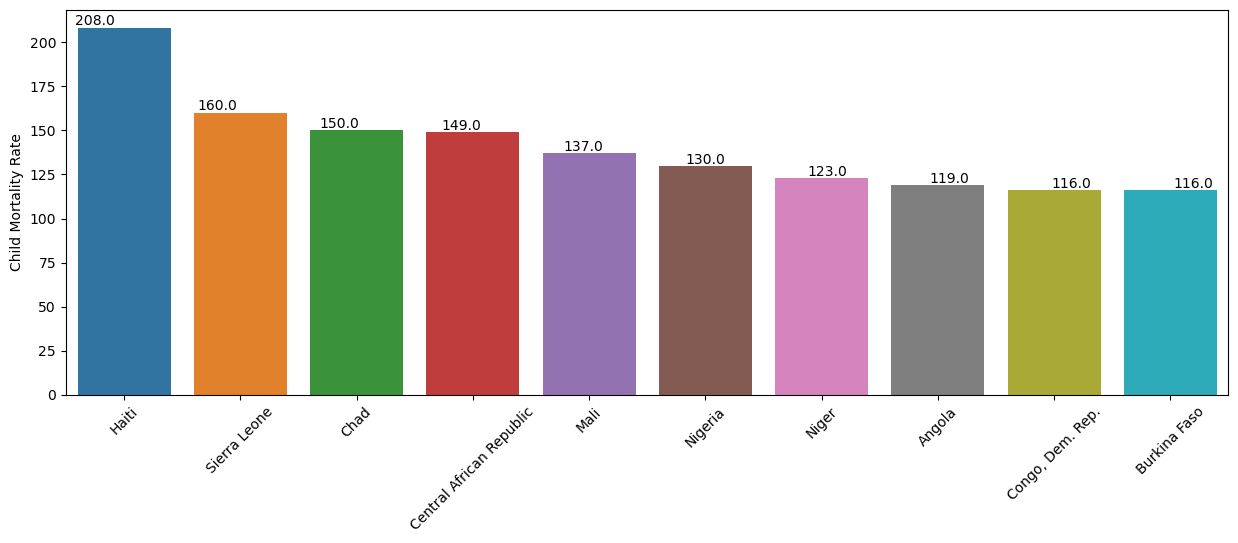

In [18]:
plt.figure(figsize = (15,5))
child_mort_top10 = countries[['country','child_mort']].sort_values('child_mort', ascending = False).head(10)
ax=sns.barplot(x='country', y='child_mort', data= child_mort_top10)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.05 , p.get_height() * 1.01))
ax.set(xlabel = '', ylabel= 'Child Mortality Rate')
plt.xticks(rotation=45)

### Top 10 coountries with the lowest spending on health

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Eritrea'),
  Text(1, 0, 'Madagascar'),
  Text(2, 0, 'Central African Republic'),
  Text(3, 0, 'Niger'),
  Text(4, 0, 'Myanmar'),
  Text(5, 0, 'Mozambique'),
  Text(6, 0, 'Pakistan'),
  Text(7, 0, 'Congo, Dem. Rep.'),
  Text(8, 0, 'Bangladesh'),
  Text(9, 0, 'Burundi')])

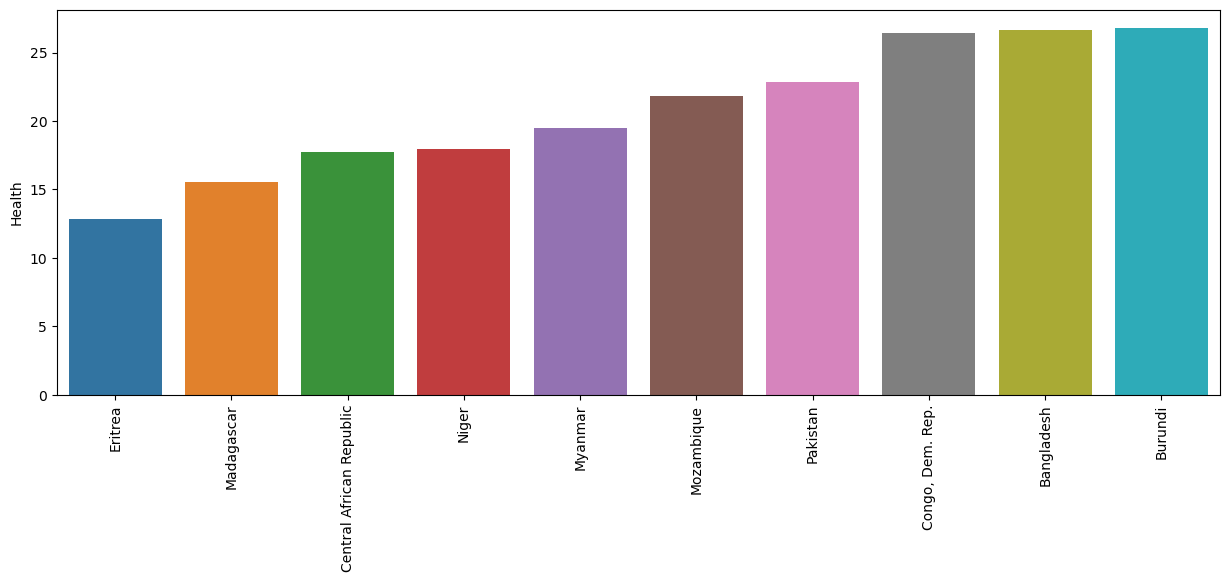

In [19]:
plt.figure(figsize = (15,5))
health = countries[['country','health']].sort_values('health', ascending = True).head(10)
ax = sns.barplot(x='country', y='health', data= health)
ax.set(xlabel = '', ylabel= 'Health')
plt.xticks(rotation=90)

### Top 10 countries with lowest per capita income

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Congo, Dem. Rep.'),
  Text(1, 0, 'Liberia'),
  Text(2, 0, 'Burundi'),
  Text(3, 0, 'Niger'),
  Text(4, 0, 'Central African Republic'),
  Text(5, 0, 'Mozambique'),
  Text(6, 0, 'Malawi'),
  Text(7, 0, 'Guinea'),
  Text(8, 0, 'Togo'),
  Text(9, 0, 'Sierra Leone')])

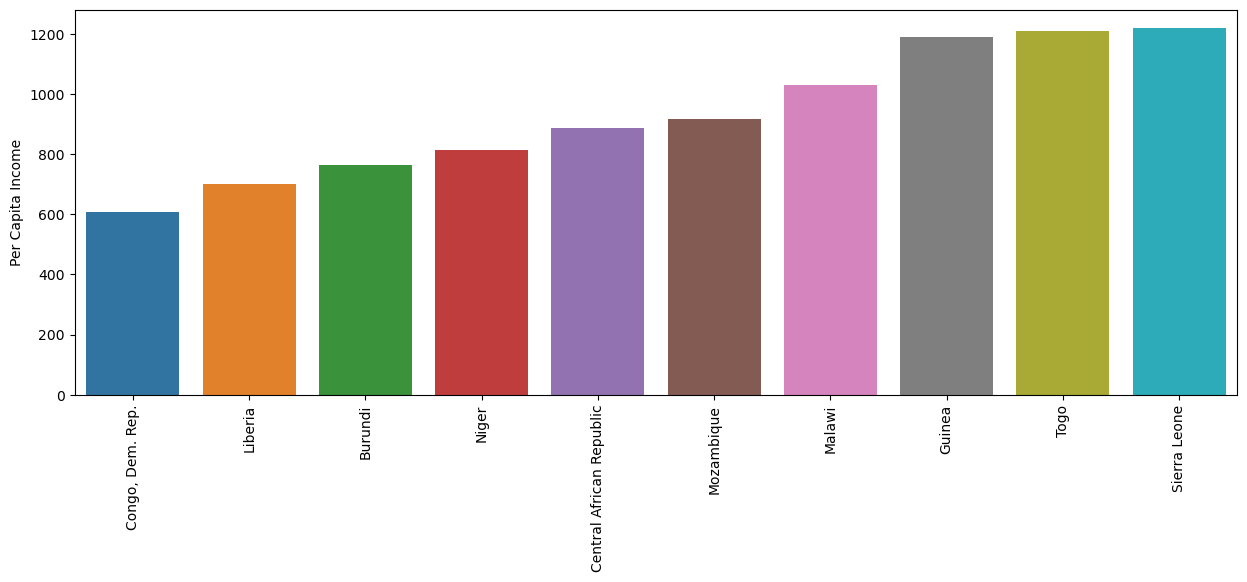

In [20]:
plt.figure(figsize = (15,5))
income_lowets_10 = countries[['country','income']].sort_values('income', ascending = True).head(10)
axes = sns.barplot(x='country', y='income', data= income_lowets_10)
axes.set(xlabel = '', ylabel= 'Per Capita Income')
plt.xticks(rotation=90)

### Top 10 Countries with the highest Inflation rate.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Nigeria'),
  Text(1, 0, 'Venezuela'),
  Text(2, 0, 'Mongolia'),
  Text(3, 0, 'Timor-Leste'),
  Text(4, 0, 'Equatorial Guinea'),
  Text(5, 0, 'Yemen'),
  Text(6, 0, 'Sri Lanka'),
  Text(7, 0, 'Angola'),
  Text(8, 0, 'Argentina'),
  Text(9, 0, 'Congo, Dem. Rep.')])

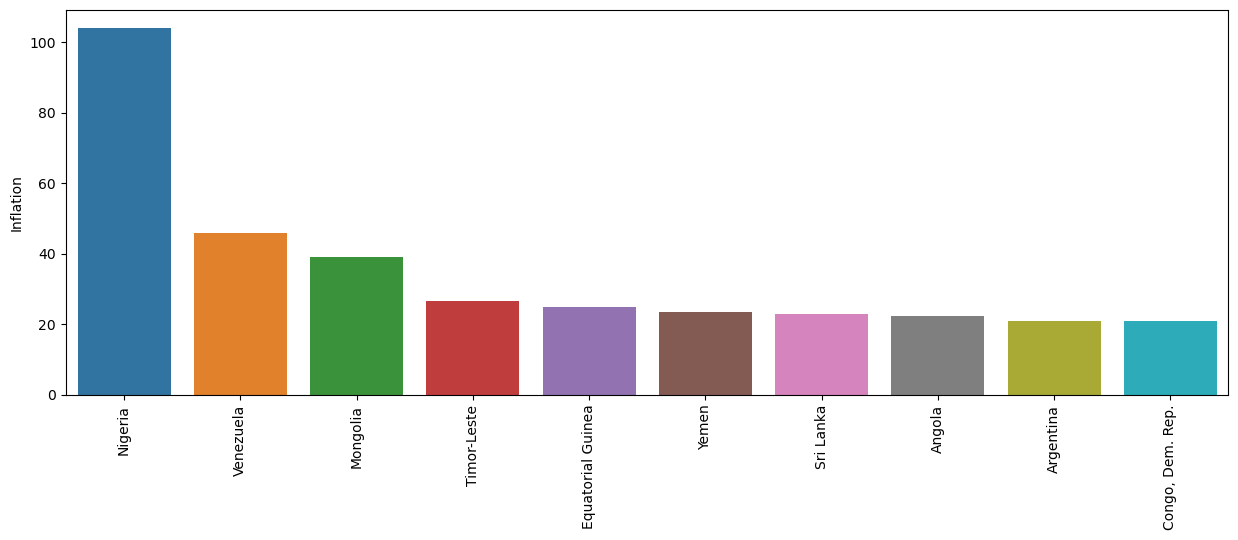

In [21]:
plt.figure(figsize = (15,5))
high_inflation = countries[['country','inflation']].sort_values('inflation', ascending = False).head(10)
ax = sns.barplot(x='country', y='inflation', data= high_inflation)
ax.set(xlabel = '', ylabel= 'Inflation')
plt.xticks(rotation=90)

From the above plot we can see that is Nigeria is clearly standing out having the highest infaltion

#### From the above visulizations we get a good idea about the under developed countries which might be in need of the NGOs aid

Checking if the dataset is fit for applying clustering on it

In [22]:
#Find the Hopkins statistic score
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [23]:
hopkins(countries.drop('country', axis = 1))

0.9370809453603786

#### we have got Hopkins score close to 1 which tends to indicate that the data is highly clustered

#### Preparing the dataset for clustering

#### Sacling the dataset

In [24]:
features = countries.columns
standard_scaler = StandardScaler()
countries_scaled= standard_scaler.fit_transform(countries.drop('country', axis=1))
countries_scaled

array([[ 1.2348468 , -0.51008966, -0.56360764, ..., -1.57290118,
         1.83898931, -0.73837646],
       [-0.58270965, -0.39606338, -0.39146172, ...,  0.7236459 ,
        -0.88967589, -0.45936668],
       [-0.3184725 , -0.33669732, -0.45386166, ...,  0.74649712,
        -0.07827425, -0.4301799 ],
       ...,
       [-0.41725274, -0.4171968 , -0.5272808 , ...,  0.35802647,
        -0.69336904, -0.6786619 ],
       [ 0.39768425, -0.4747592 , -0.54384653, ..., -0.28180754,
         1.08647972, -0.6786619 ],
       [ 1.05951187, -0.45935901, -0.53003083, ..., -2.05277669,
         1.56415972, -0.66682942]])

In [25]:
country_norm = pd.DataFrame(countries_scaled)
country_norm.columns = features[1:]
country_norm.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.234847,-0.510090,-0.563608,-0.530152,-0.856955,0.124994,-1.572901,1.838989,-0.738376
1,-0.582710,-0.396063,-0.391462,-0.321693,-0.308713,-0.336520,0.723646,-0.889676,-0.459367
2,-0.318473,-0.336697,-0.453862,-0.392076,-0.113006,0.745941,0.746497,-0.078274,-0.430180
3,1.946065,-0.285794,-0.518900,-0.378423,-0.574267,1.333323,-1.127302,2.061470,-0.503541
4,-0.738289,0.064875,-0.035126,0.301255,0.295540,-0.620888,0.780774,-0.575585,0.180376


#### Finding the Silhouette score

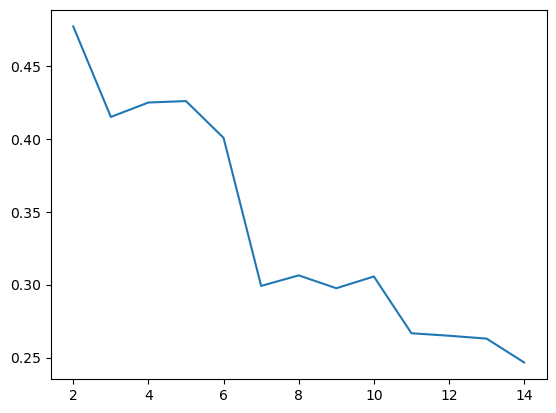

In [26]:
from sklearn.metrics import silhouette_score
ss = []
for k in range(2, 15):
    kmean = KMeans(n_clusters = k).fit(country_norm)
    ss.append([k, silhouette_score(country_norm, kmean.labels_)])
temp = pd.DataFrame(ss)    
plt.plot(temp[0], temp[1])

### Elbow score

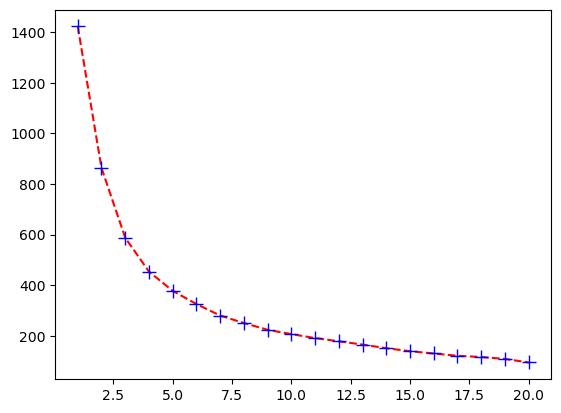

In [27]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(country_norm)
    ssd.append(model_clus.inertia_)

    
fig, ax = plt.subplots()
ax.plot(range(1,21),ssd, marker = '+',color = 'red' , ls = '--', markeredgecolor = 'blue', markersize = '10')

#### By looking silhouette plot, we see the highest peak is at k = 4 and in sum of squared distances plot , we see that the elbow is in the range of 3 to 5 , so let us take k as 3

#### Performing K-Means Clustering on the scaled dataset

In [28]:
kmeans_clus4 = KMeans(n_clusters=3, max_iter=50, random_state= 50)
kmeans_clus4.fit(country_norm)

KMeans(max_iter=50, n_clusters=3, random_state=50)

In [29]:
kmeans_clus4.labels_

array([2, 1, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1,
       0, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0, 0, 1,
       1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 1,
       0, 1, 1, 1, 2, 0, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2, 2, 1, 1,
       1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 0, 2, 2, 1,
       2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 0, 2, 2, 0,
       0, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 2, 2])

In [30]:
#Finding the labels and converting it to series so that it can be appended to the `original countries` easily.
labels_kmeans = pd.Series(kmeans_clus4.labels_, index=countries.index)

In [31]:
#Adding the labels to countries dataset
countries_kmeans = countries.copy()
countries_kmeans['Labels'] = labels_kmeans
countries_kmeans.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1


### Checking the number of countries assigned to each clusters

In [32]:
countries_kmeans['Labels'].value_counts()

1    83
2    48
0    27
Name: Labels, dtype: int64

## Profiling the clusters based on - [gdpp, child_mort and income]

Bivariate analysis of clustered countries


[Text(0.5, 0, 'GDPP'), Text(0, 0.5, 'Child Mortality Rate')]

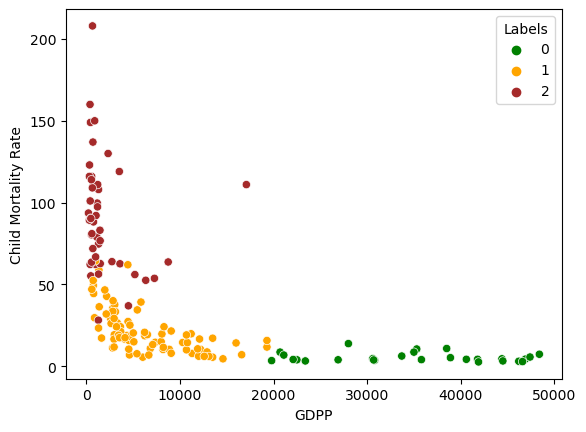

In [33]:
axes = sns.scatterplot(x='gdpp',y='child_mort',hue='Labels',legend='full',data=countries_kmeans, palette=['green','orange','brown','red'])
axes.set(xlabel = 'GDPP', ylabel= 'Child Mortality Rate')

### Observation 
-  Countries with low GDPP have high child mortality



[Text(0.5, 0, 'GDPP'), Text(0, 0.5, 'Income')]

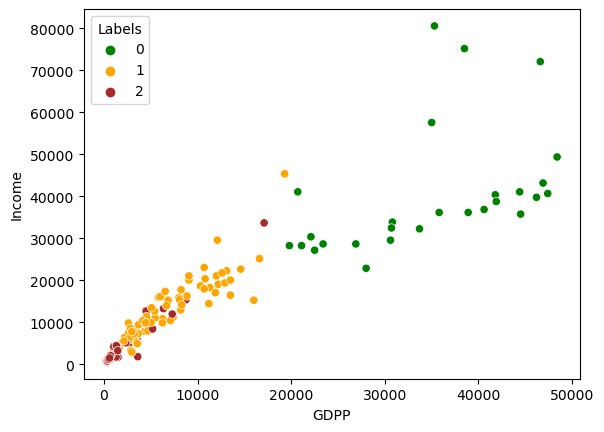

In [34]:
axes = sns.scatterplot(x='gdpp',y='income',hue='Labels',legend='full',data=countries_kmeans, palette=['green','orange','brown','red'])
axes.set(xlabel = 'GDPP', ylabel= 'Income')

### Observation
-  countries with low income have have lower GDPP and vice versa

[Text(0.5, 0, 'Child Mortality Rate'), Text(0, 0.5, 'Income')]

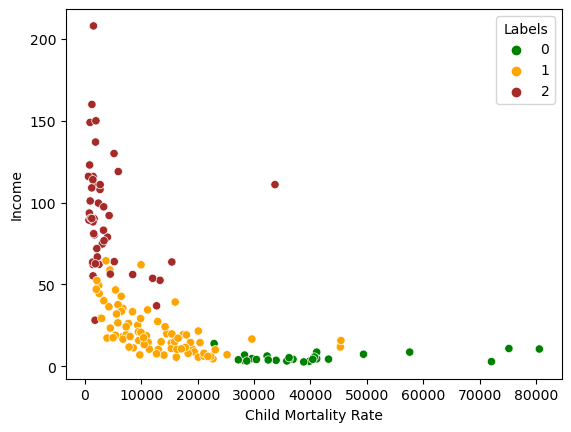

In [35]:
axes= sns.scatterplot(x='income',y='child_mort',hue='Labels',legend='full',data=countries_kmeans, palette=['green','orange','brown','red'])
axes.set(xlabel = 'Child Mortality Rate', ylabel= 'Income')

### Observation
-  In the income vs child_mort, when income is high the child        mortality is low and vice versa

Taking mean and analyzing the cluster further

In [36]:
child_mort_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).child_mort.mean())
exports_mean=pd.DataFrame(countries_kmeans.groupby(["Labels"]).exports.mean())
health_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).health.mean())
imports_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).imports.mean())
income_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).income.mean())
inflat_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).inflation.mean())
life_expec_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).life_expec.mean())
total_fer_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).total_fer.mean())
gdpp_mean =pd.DataFrame(countries_kmeans.groupby(["Labels"]).gdpp.mean())

In [37]:
cluster_analysis_df = pd.concat([pd.Series([0,1,2]),child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflat_mean,life_expec_mean,
                                 total_fer_mean,gdpp_mean], axis=1)

In [38]:
cluster_analysis_df.columns = ["Labels","child_mort_mean","exports_mean","health_mean","imports_mean","income_mean","inflation_mean","life_expec_mean","total_fer_mean","gdpp_mean"]
cluster_analysis_df

,Labels,child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflation_mean,life_expec_mean,total_fer_mean,gdpp_mean
0,0,5.433333,18352.233333,3122.890741,16582.611111,40292.592593,2.793370,79.807407,1.731111,34907.407407
1,1,21.771084,2908.157813,405.906631,3021.140013,12460.120482,7.621012,72.968675,2.279036,6411.710843
2,2,91.610417,879.063521,114.821765,827.028771,3897.354167,11.911146,59.239583,4.992083,1909.208333


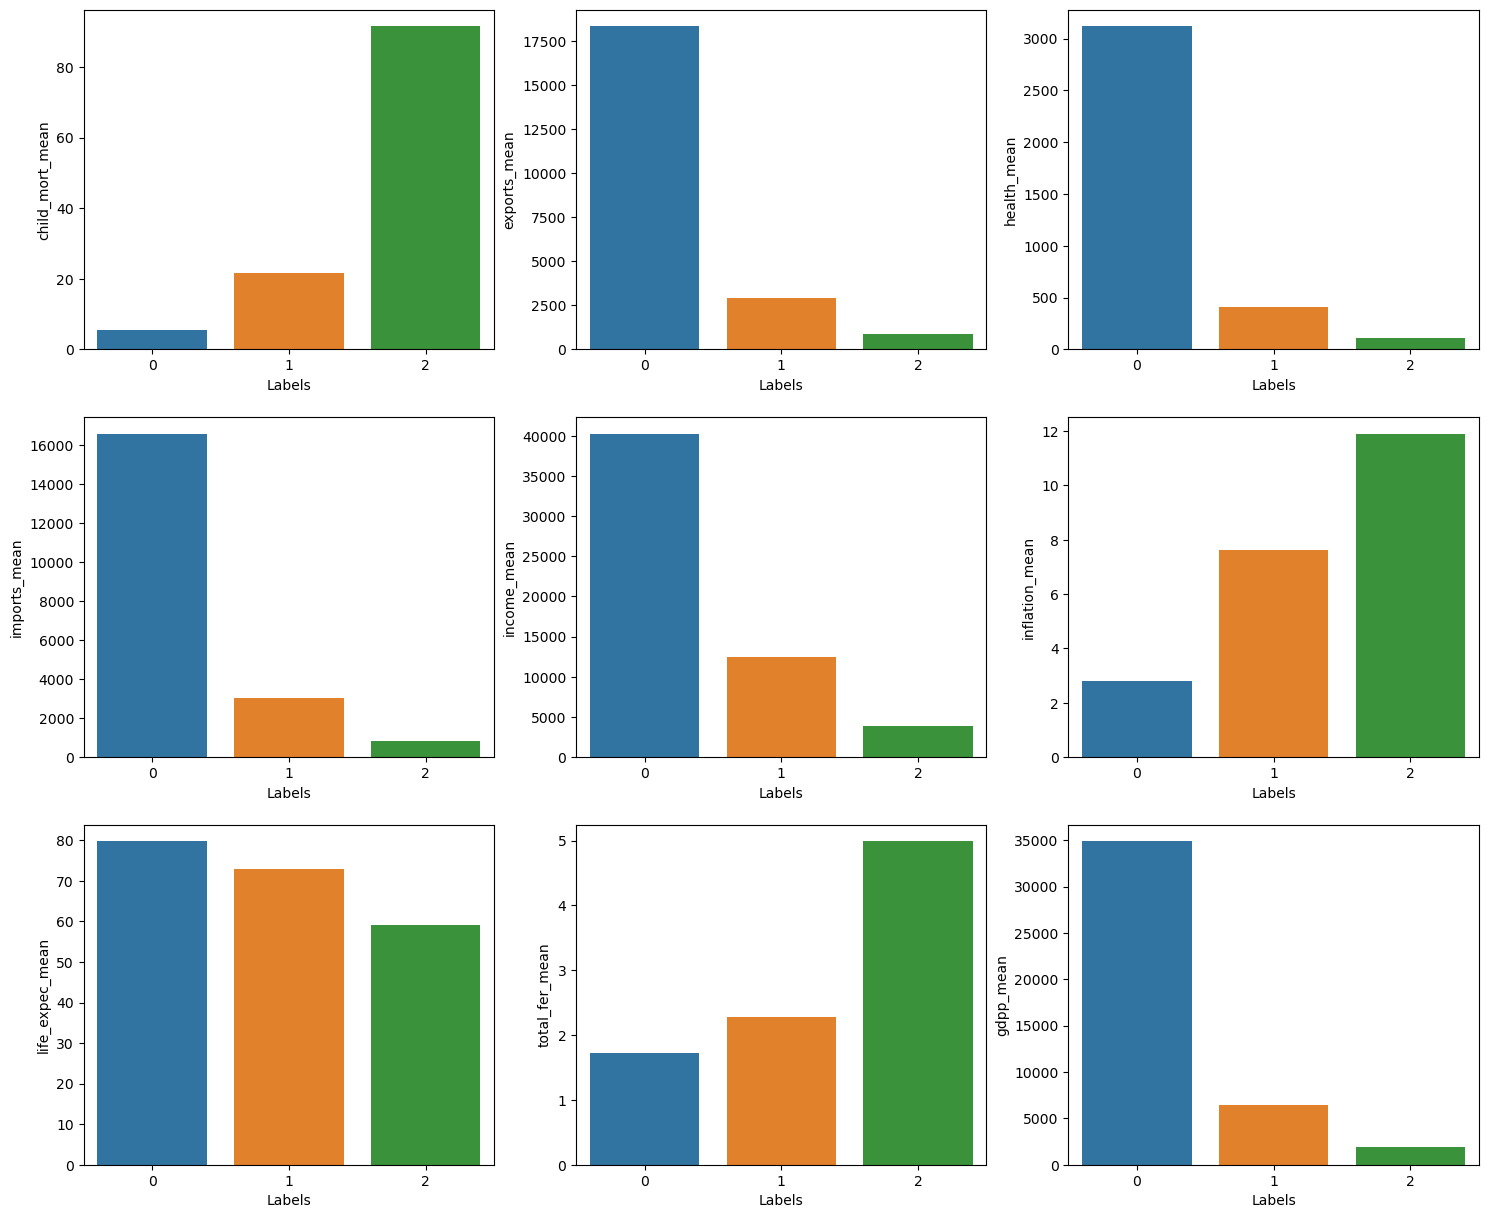

In [39]:
features = cluster_analysis_df.columns
fig = plt.figure(figsize=(18,15))
for plot, feature in enumerate(features[1:]):
    fig.add_subplot(3,3,plot+1)
    sns.barplot(x=cluster_analysis_df.Labels,y=cluster_analysis_df[feature])

### From the above plot we can see that the criteria GDPP, income and child mortality are satisfied by cluster labeled 2

In [42]:
#Binning the clusters to get the top 5 countries sorted in order exaplined above
clustered_kmeans=countries[countries_kmeans['Labels']==2]
clustered_kmeans.sort_values(['gdpp','income','child_mort','health','inflation','life_expec','total_fer','imports','exports'], 
                      ascending=[True,True,False,True,False,True,False,False,True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220,17.20,55.0,5.20,399
93,Madagascar,62.2,103.2500,15.5701,177.590,1390,8.79,60.8,4.60,413
106,Mozambique,101.0,131.9850,21.8299,193.578,918,7.64,54.5,5.56,419
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.01,47.5,5.21,446
94,Malawi,90.5,104.6520,30.2481,160.191,1030,12.10,53.1,5.31,459
50,Eritrea,55.2,23.0878,12.8212,112.306,1420,11.60,61.7,4.61,482


#### So from the above results and analysis, we can conclude that as per K-means clustering, the countries which needs the HELP most are 

1  Burundi

2  Liberia

3  Congo,dem.Rep

4  Niger

5  Sierra Leone

### Taking Hierarchical Clustering approach

#### Using the already cleaned and scaled data that was used for kmeans clustering 

In [43]:
country_norm.shape

(158, 9)

In [45]:
country_norm.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.234847,-0.510090,-0.563608,-0.530152,-0.856955,0.124994,-1.572901,1.838989,-0.738376
1,-0.582710,-0.396063,-0.391462,-0.321693,-0.308713,-0.336520,0.723646,-0.889676,-0.459367
2,-0.318473,-0.336697,-0.453862,-0.392076,-0.113006,0.745941,0.746497,-0.078274,-0.430180
3,1.946065,-0.285794,-0.518900,-0.378423,-0.574267,1.333323,-1.127302,2.061470,-0.503541
4,-0.738289,0.064875,-0.035126,0.301255,0.295540,-0.620888,0.780774,-0.575585,0.180376


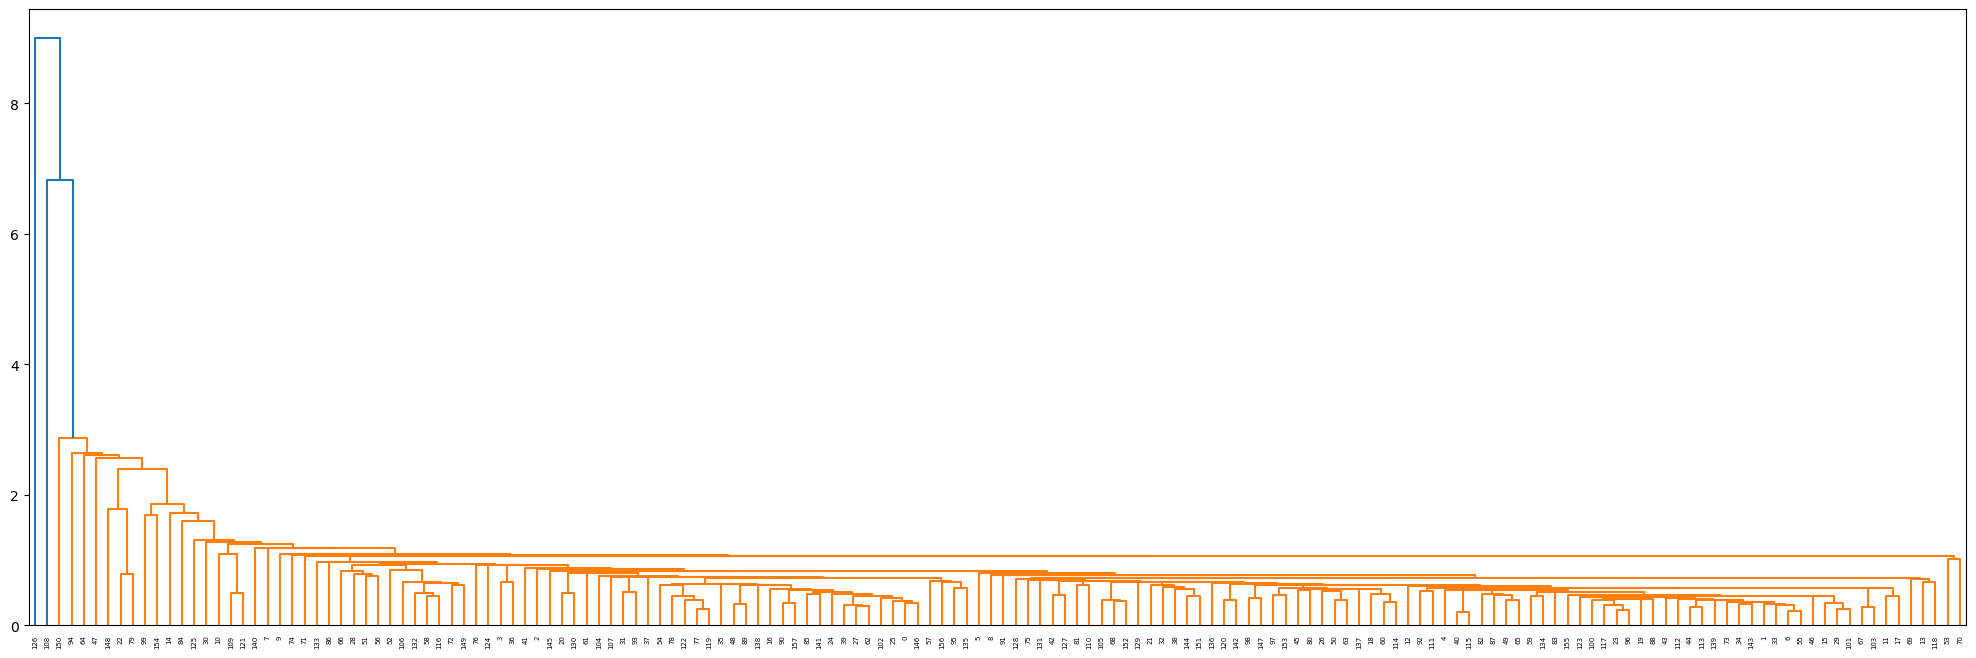

In [46]:
countries_hrcl  = country_norm.copy()
fig = plt.figure(figsize = (25,8))
mergings = linkage(countries_hrcl, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

### By single method heirarchical clustering tings are not clear, so let us go for complete heirarchical clustering method

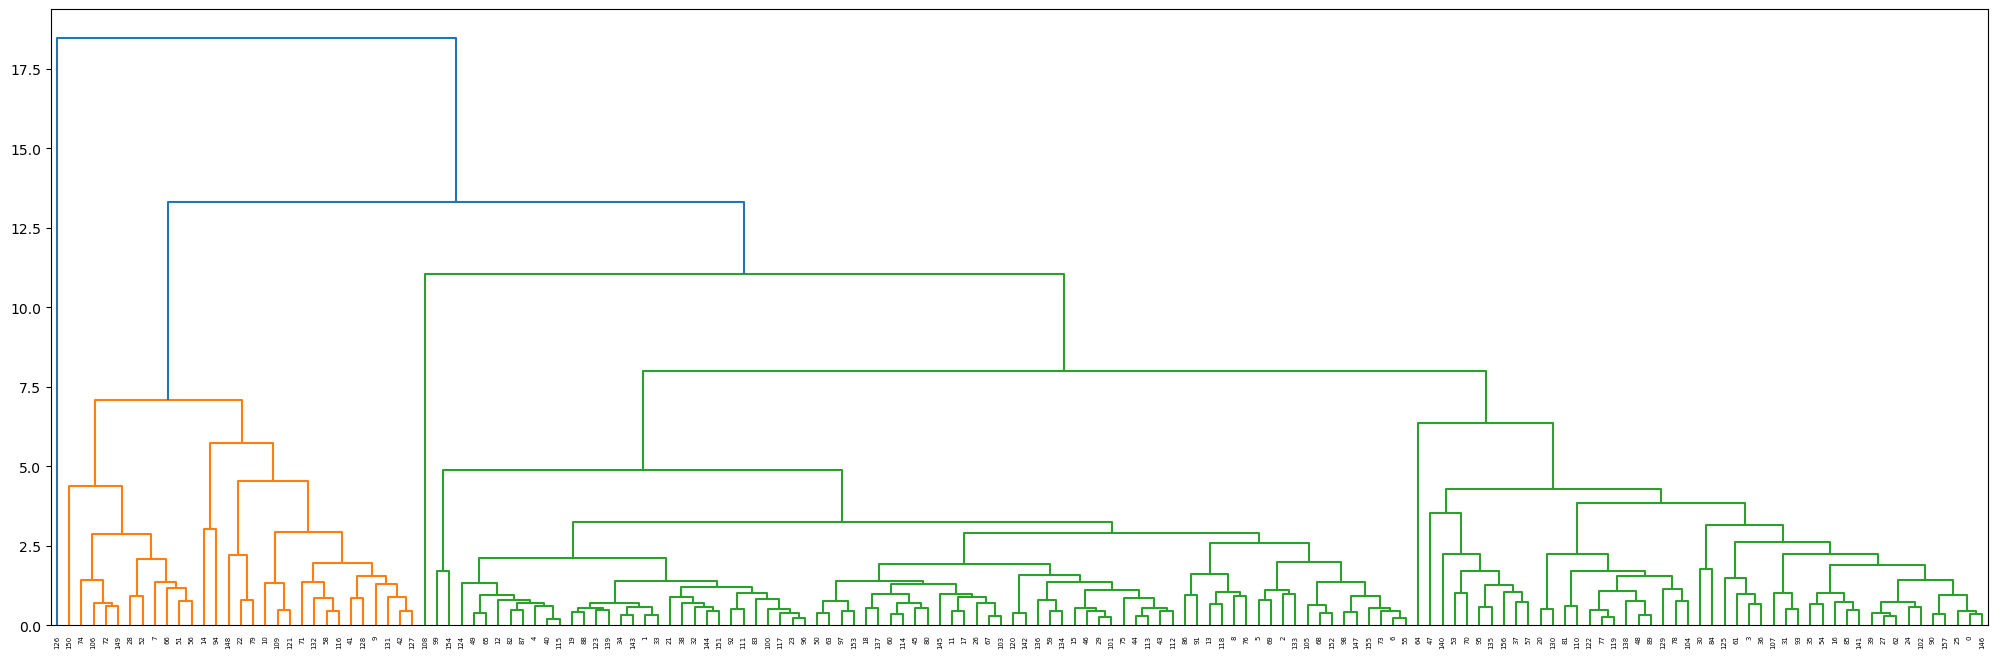

In [47]:
# HC with complete method
fig = plt.figure(figsize = (25, 8))
mergings = linkage(countries_hrcl, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

#### At 12.5 there are 3 clusters, we will move with 3 clusters

#### Let us cut dendrogram such that there are n_clusters=3

In [48]:
countries

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,1384.02,155.9250,1565.190,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,3847.50,662.8500,2376.000,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,943.20,89.6040,1050.620,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,393.00,67.8580,450.640,4480,23.60,67.5,4.67,1310


In [49]:
clusterCut = cut_tree(mergings, n_clusters = 3).reshape(-1,)
clusterCut

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0])

In [50]:
countries_hrcl_cluster = countries.copy()
countries_hrcl_cluster.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [51]:
countries_hrcl_cluster['Labels'] = pd.Series(clusterCut, index=countries.index)
countries_hrcl_cluster.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0


#### Checking the number of countries assigned to each clusters

In [53]:
countries_hrcl_cluster['Labels'].value_counts()

0    128
1     29
2      1
Name: Labels, dtype: int64

####  The above numbers are quite different from the one which we got in Kmeans method. 

### Profiling the clusters based on - [gdpp, child_mort and income]

#### Bivariate anaysis of clustered countries

[Text(0.5, 0, 'GDPP'), Text(0, 0.5, 'Child Mortality Rate')]

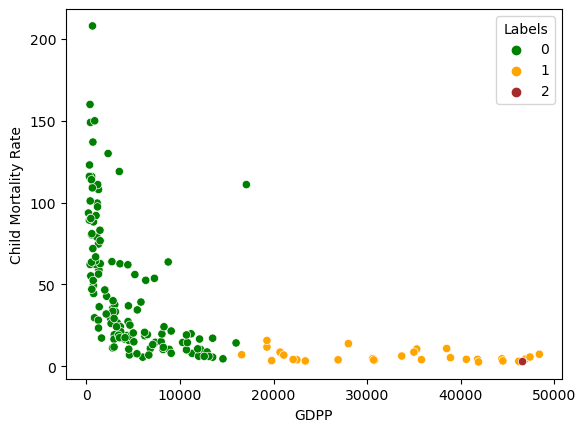

In [54]:
axes = sns.scatterplot(x='gdpp', y='child_mort', hue='Labels',legend='full',data=countries_hrcl_cluster, palette=['green','orange','brown','red'])
axes.set(xlabel = 'GDPP', ylabel= 'Child Mortality Rate')

[Text(0.5, 0, 'GDPP'), Text(0, 0.5, 'Income')]

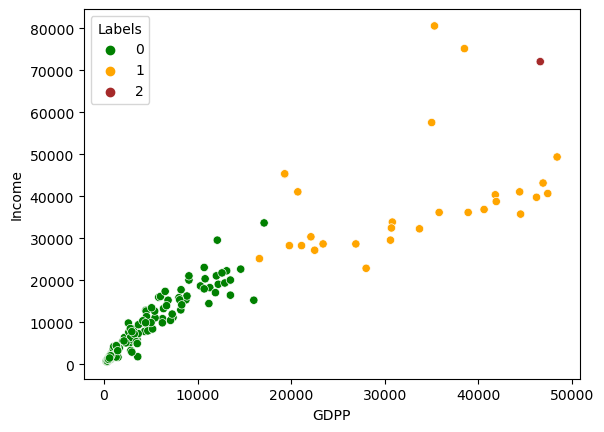

In [55]:
axes = sns.scatterplot(x='gdpp',y='income',hue='Labels',legend='full',data=countries_hrcl_cluster, palette=['green','orange','brown','red'])
axes.set(xlabel = 'GDPP', ylabel= 'Income')

[Text(0.5, 0, 'Child Mortality Rate'), Text(0, 0.5, 'Income')]

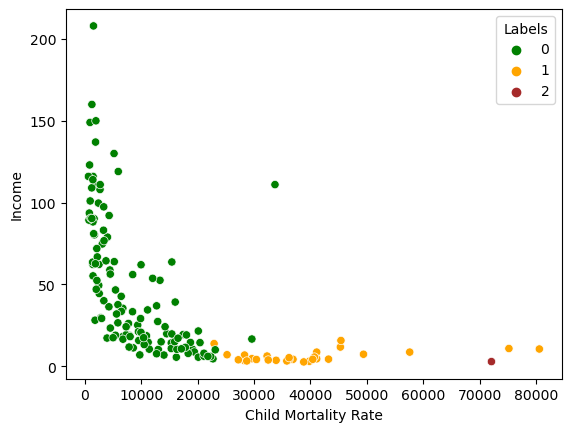

In [56]:
axes= sns.scatterplot(x='income',y='child_mort',hue='Labels',legend='full',data=countries_hrcl_cluster, palette=['green','orange','brown','red'])
axes.set(xlabel = 'Child Mortality Rate', ylabel= 'Income')

### From the above 3 scatterplots we can deduce the following insights about the clusters, specially about the clster labeled 0

- In the gdpp vs child_mort plot, the child_mort is high when gdpp   is low.
- In the gdpp vs income, when the gdpp is average the income is     average.
- In the income vs child_mort, when income is high the child         mortality is low and vice versa.

### Taking mean of the features for further analysis

In [57]:
child_mort_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).child_mort.mean())
exports_mean=pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).exports.mean())
health_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).health.mean())
imports_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).imports.mean())
income_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).income.mean())
inflat_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).inflation.mean())
life_expec_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).life_expec.mean())
total_fer_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).total_fer.mean())
gdpp_mean =pd.DataFrame(countries_hrcl_cluster.groupby(["Labels"]).gdpp.mean())

In [60]:
hrcl_cluster_analysis_df = pd.concat([pd.Series([0,1,2]),child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflat_mean,life_expec_mean,
                                 total_fer_mean,gdpp_mean], axis=1)

In [61]:
hrcl_cluster_analysis_df.columns = ["Labels","child_mort_mean","exports_mean","health_mean","imports_mean","income_mean","inflation_mean","life_expec_mean","total_fer_mean","gdpp_mean"]
hrcl_cluster_analysis_df

,Labels,child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflation_mean,life_expec_mean,total_fer_mean,gdpp_mean
0,0,48.202344,1942.605059,284.218555,2056.379704,8635.648438,9.148391,67.759375,3.292891,4442.296875
1,1,6.148276,15076.862069,2941.186552,13582.134483,39024.137931,3.750069,79.268966,1.823448,32796.551724
2,2,2.800000,93200.000000,1845.360000,81084.000000,72100.000000,-0.046000,82.700000,1.150000,46600.000000


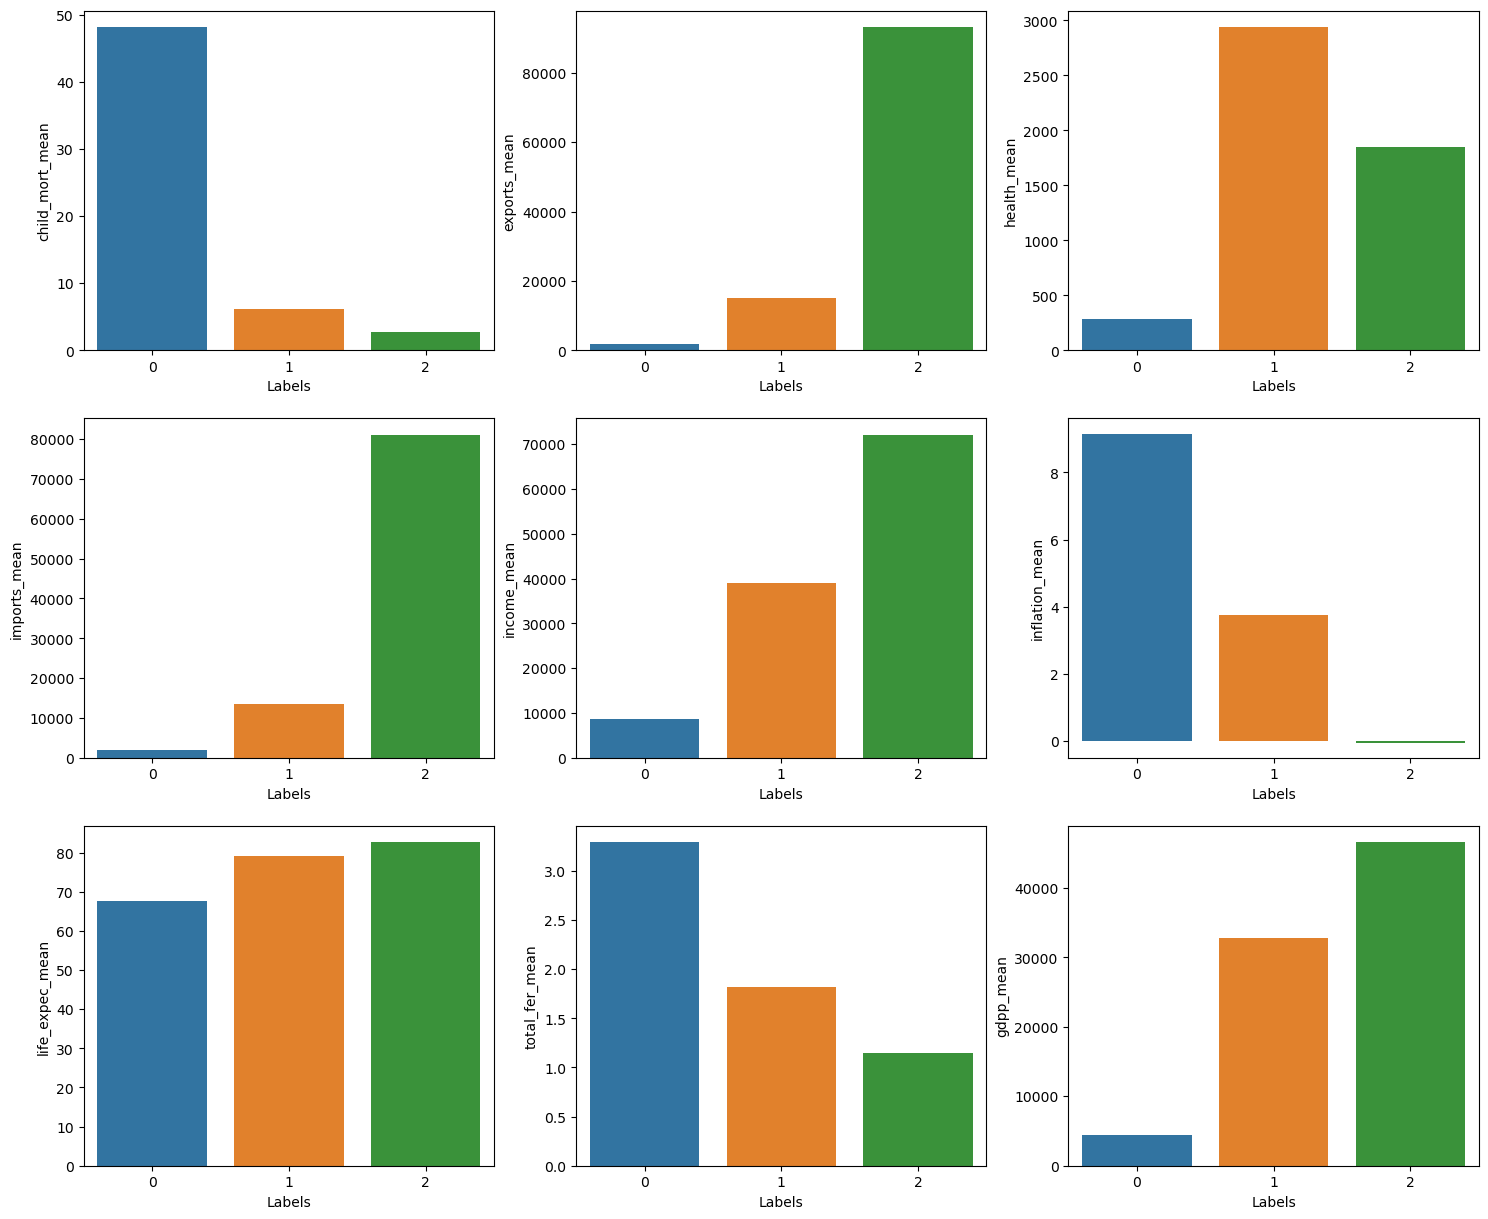

In [63]:
features = hrcl_cluster_analysis_df.columns
fig = plt.figure(figsize=(18,15))
for plot, feature in enumerate(features[1:]):
    fig.add_subplot(3,3,plot+1)
    sns.barplot(x=hrcl_cluster_analysis_df.Labels,y= hrcl_cluster_analysis_df[feature])

In [64]:
#Binning the clusters to get the top 5 countries sorted in order exaplined above
clustered_hrcl=countries[countries_hrcl_cluster['Labels']==0]
clustered_hrcl.sort_values(['gdpp','income','child_mort','health','inflation','life_expec','total_fer','imports','exports'], 
                      ascending=[True,True,False,True,False,True,False,False,True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220,17.20,55.0,5.20,399
93,Madagascar,62.2,103.2500,15.5701,177.590,1390,8.79,60.8,4.60,413
106,Mozambique,101.0,131.9850,21.8299,193.578,918,7.64,54.5,5.56,419
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.01,47.5,5.21,446
94,Malawi,90.5,104.6520,30.2481,160.191,1030,12.10,53.1,5.31,459
50,Eritrea,55.2,23.0878,12.8212,112.306,1420,11.60,61.7,4.61,482


### So from the above results and analysis, we can conclude that as per Heirarchical clustering, the country which badly need HELP are

1. Burundi

2. Liberia

3. Congo,Dem.Rep

4. Niger

5. Sierra Leone